#### **Multi-output models**

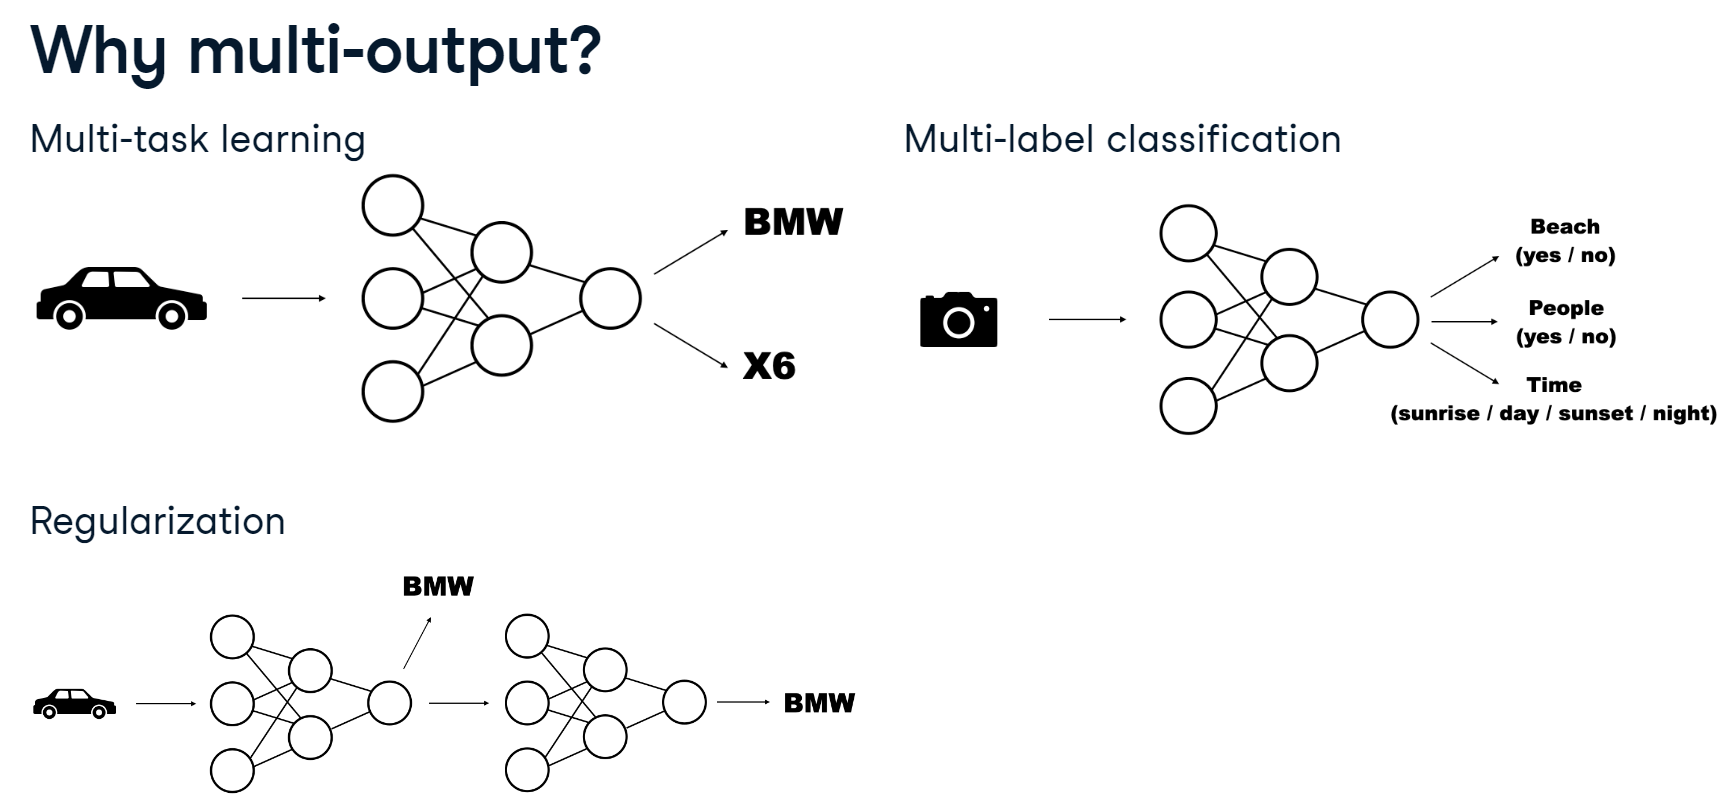

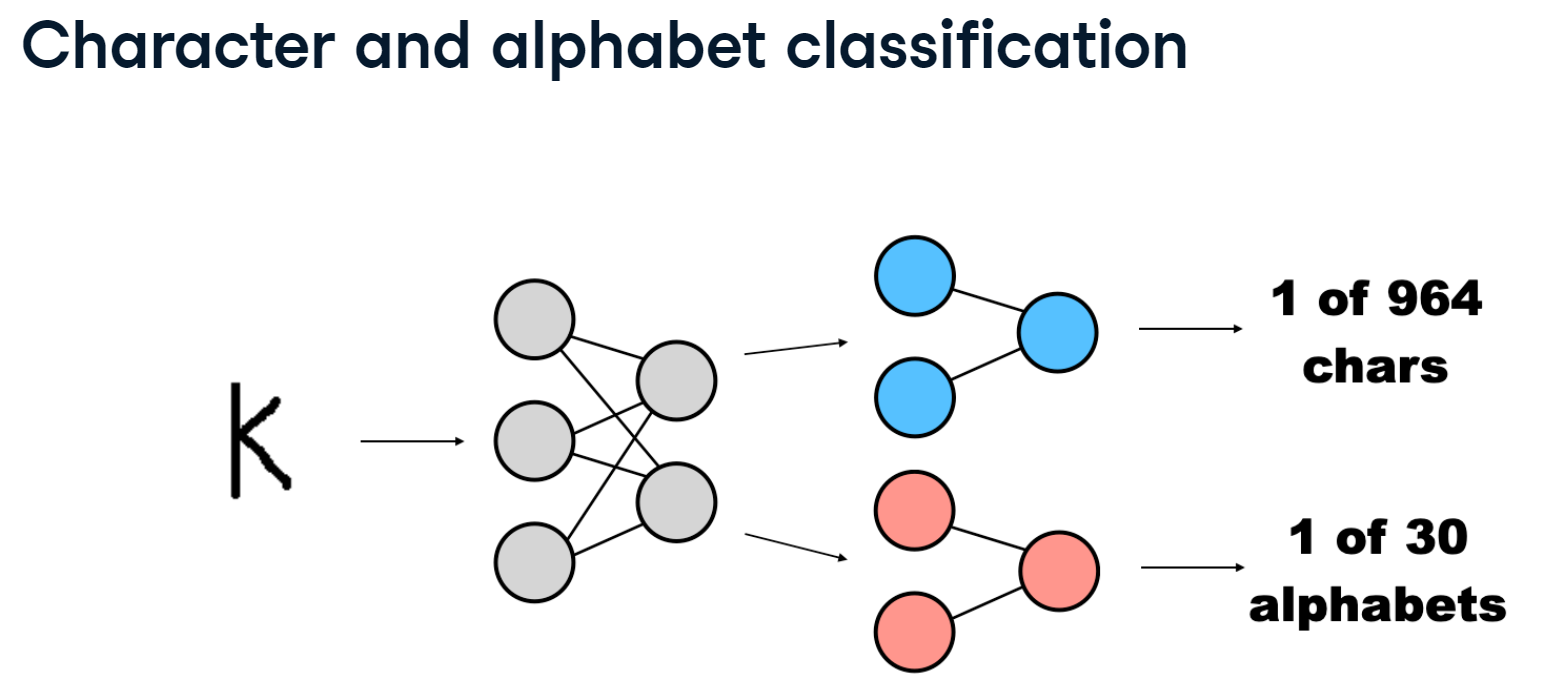

In [ ]:
from PIL import Image

# Two-output Dataset

class OmniglotDataset(Dataset):
    def __init__(self, transform, samples):
        self.transform = transform
        self.samples = samples

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, alphabet, label = self.sampels[idx]
        img = Image.open(img_path).convert('L')
        img = self.transform(img)
        return img, alphabet, label

In [ ]:
import torch
import torch.nn as nn

# Two-output architecture

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.image_layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ELU(),
            nn.Flatten(),
            nn.Linear(16*32*32, 128)
        )
        
        self.classifier_alpha = nn.Linear(128, 30)
        self.classifier_char = nn.Linear(128, 964)
        
    def forward(self, x):
        x_image = self.image_layer(x)
        output_alpha = self.classifier_alpha(x_image)
        output_char = self.classifier_char(x_image)
        return output_alpha, output_char

In [ ]:
# Training loop

for epoch in range(10):
    for images, labels_alpha, labels_char in dataloader_train:
        optimizer.zero_grad()
        outputs_alpha, outputs_char = net(images)
        loss_alpha = criterion(outputs_alpha, labels_alpha)
        loss_char = criterion(outputs_char, labels_char)
        loss = loss_alpha + loss_char   # We can update loss sum to prioratize alphabet classification or character classification by multiplying it with the degree we want to increase it's priority. Right now, the model weights both alpha and char to be equally important. we can chage it by, say, loss = loss_alpha + loss_char*2, if we want to prioratize char classification. or we can assign weights to both losses to sum them out to 1 (loss = loss_alpha*0.33 + loss_char*0.67)
        loss.backward()
        optimizer.step()

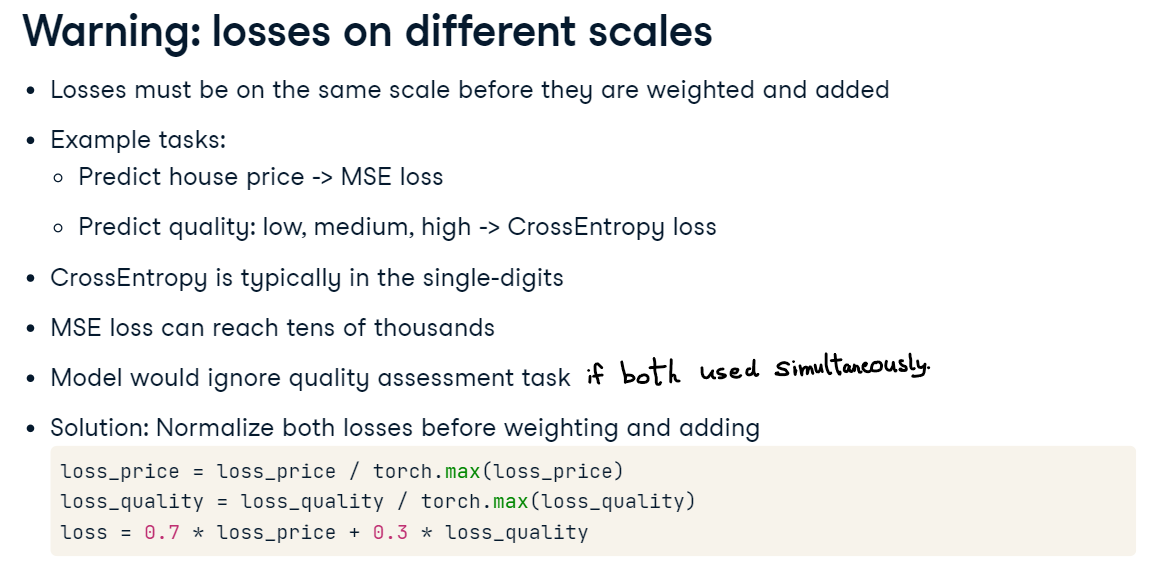

#### **Evaluating Multi-output models and loss Weighting**

In [ ]:
# Model Evaluation
from torchmetrics import Accuracy

acc_alpha = Accuracy(task='multiclass', num_classes=30)
acc_char = Accuracy(task='multiclass', num_classes=964)

net.eval()

with torch.no_grad():
    for images, labels_alpha, labels_char in dataloader_test:
        out_alpha, out_char = net(images)
        _, pred_alpha = torch.max(out_alpha, 1)
        _, pred_char = torch.max(out_char, 1)
        acc_alpha(pred_alpha, labels_alpha)
        acc_char(pred_char, labels_char)

print(f'Alphabet: {acc_alpha.compute()}')
print(f'Character: {acc_char.compute()}')